In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

#from utils import confusion_matrix



In [64]:
csv_filename = '/content/drive/MyDrive/motionProject/2023-02-14_6axis_data.csv'
df = pd.read_csv(csv_filename, encoding='utf8', low_memory=False) # utf8, cp949 |
df.shape


(3105, 8)

In [65]:
df

,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
0,1,idle,-8.9204,-1.0481,4.2497,-5.4917,-8.9241,-6.8647
1,1,idle,-8.9396,-1.0576,4.2592,-6.1782,-10.2970,-5.4917
2,1,idle,-8.9587,-1.0672,4.2353,-4.8053,-8.9241,-6.8647
3,1,idle,-8.9539,-1.0337,4.2353,-4.8053,-6.8647,-10.2970
4,1,idle,-8.9157,-1.0720,4.2497,-8.2376,-8.2376,-15.1022
...,...,...,...,...,...,...,...,...
3100,53,sit,-9.2602,-0.0335,3.5701,108.4616,-59.0360,-38.4421
3101,53,sit,-9.2507,-0.0287,3.5749,114.6397,-54.9172,-53.5443
3102,53,sit,-9.2315,-0.0096,3.5174,113.2668,-51.4849,-52.1714
3103,53,sit,-9.2650,0.0479,3.4839,105.0292,-50.7984,-55.6037


In [66]:
display(df.head())

display(df.tail())

,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
0,1,idle,-8.9204,-1.0481,4.2497,-5.4917,-8.9241,-6.8647
1,1,idle,-8.9396,-1.0576,4.2592,-6.1782,-10.2970,-5.4917
2,1,idle,-8.9587,-1.0672,4.2353,-4.8053,-8.9241,-6.8647
3,1,idle,-8.9539,-1.0337,4.2353,-4.8053,-6.8647,-10.2970
4,1,idle,-8.9157,-1.0720,4.2497,-8.2376,-8.2376,-15.1022


,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
3100,53,sit,-9.2602,-0.0335,3.5701,108.4616,-59.0360,-38.4421
3101,53,sit,-9.2507,-0.0287,3.5749,114.6397,-54.9172,-53.5443
3102,53,sit,-9.2315,-0.0096,3.5174,113.2668,-51.4849,-52.1714
3103,53,sit,-9.2650,0.0479,3.4839,105.0292,-50.7984,-55.6037
3104,53,sit,-9.2698,0.0144,3.4792,96.1052,-47.3661,-63.8413


In [67]:
train = df[['accX','accY','accZ','gyroX','gyroY','gyroZ']]

In [68]:
test = df['label']

In [69]:
test.unique()

array(['idle', 'sit', 'standup'], dtype=object)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.33, random_state=42)
# train-test data split
# X는 input, Y는 (정답)output

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2080, 6), (1025, 6), (2080,), (1025,))

In [72]:
epochs = 15
batch_size = 16
n_hidden = 32

In [73]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [74]:
# To reshape the data, convert the DataFrames to NumPy arrays first and then perform the reshape operation.

X_train = X_train.values
X_test = X_test.values

In [75]:
X_train

array([[-8.513700e+00,  5.551000e-01,  2.196600e+00,  5.491700e+00,
        -2.182960e+02,  1.372900e+00],
       [-9.485100e+00,  5.599000e-01,  3.919400e+00, -5.354430e+01,
         8.786760e+01, -3.157740e+01],
       [-1.030350e+01, -3.206000e-01,  1.201200e+00,  8.924050e+01,
         6.864700e+00,  8.100290e+01],
       ...,
       [-9.671800e+00, -3.830000e-02,  3.378700e+00, -8.855400e+01,
        -2.670351e+02,  2.471280e+01],
       [-9.011400e+00,  6.700000e-02,  4.177900e+00, -8.924100e+00,
        -1.098340e+01, -1.372930e+01],
       [-1.092560e+01, -5.025000e-01, -4.546000e-01,  1.441580e+01,
         2.608570e+01, -9.747810e+01]])

In [76]:
y_train = y_train.values
y_test = y_test.values

In [77]:
# reshape input to be 3D [samples, timesteps, features]
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [78]:
X_train.shape

(2080, 1, 6)

In [79]:
X_test.shape

(1025, 1, 6)

In [80]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2080, 1, 6) (2080,) (1025, 1, 6) (1025,)


In [81]:
# 분류하고 싶은 클래스 개수
n_classes = _count_classes(y_train) 
n_classes

3

In [82]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# ['PC' 'TABLET' 'MOBILE'] ==> [1 2 0]

In [83]:
from keras.utils import to_categorical

# 원 핫 인코딩 
#    0 1 2
# 1  0 1 0
# 2  0 0 1
# 0  1 0 0

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [84]:
model = Sequential()

# n_hidden : 은닉계층에 임베딩되는 차원
# LSTM cell =  n_hidden 차원으로 만드는 것
# timestep : split해서 넣을 데이터 절편 크기
# X_train = (1762, 1, 6)
model.add(LSTM(n_hidden, input_shape=(X_train.shape[1], X_train.shape[2])))
# input차원 - (timesteps, input_dim)

model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# loss : predicted 결과와 real 결과의 차이
# optimizer : local optimum에 빠지지 않도록 넘어가게 해주는 장치, Adam 많이 씀
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate
# print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/15
130/130 [==============================] - 4s 12ms/step - loss: 1.0668 - accuracy: 0.4476 - val_loss: 0.7726 - val_accuracy: 0.7259
Epoch 2/15
130/130 [==============================] - 1s 7ms/step - loss: 0.7896 - accuracy: 0.6471 - val_loss: 0.6267 - val_accuracy: 0.7444
Epoch 3/15
130/130 [==============================] - 1s 5ms/step - loss: 0.6958 - accuracy: 0.6764 - val_loss: 0.5573 - val_accuracy: 0.7688
Epoch 4/15
130/130 [==============================] - 1s 4ms/step - loss: 0.6303 - accuracy: 0.7091 - val_loss: 0.5296 - val_accuracy: 0.7688
Epoch 5/15
130/130 [==============================] - 1s 4ms/step - loss: 0.6088 - accuracy: 0.7115 - val_loss: 0.5115 - val_accuracy: 0.7571
Epoch 6/15
130/130 [==============================] - 1s 4ms/step - loss: 0.5924 - accuracy: 0.7135 - val_loss: 0.4956 - val_accuracy: 0.7639
Epoch 7/15
130/130 [==============================] - 1s 4ms/step - loss: 0.5787 - accuracy: 0.7274 - val_loss: 0.4886 - val_accuracy: 0.7707
Epoch

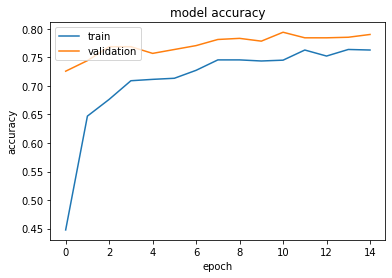

In [85]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [87]:
from sklearn.metrics import confusion_matrix

y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test_classes, y_pred_classes))

33/33 [==============================] - 0s 2ms/step
[[231   1   5]
 [  9 267 142]
 [  1  57 312]]


### 랜덤 인풋에 따른 예측결과

In [88]:
test_data1 = np.array([[-10.5476, -0.1819, 0.4068, 88.554, 243.0088, -61.0954], [-10.9256, -0.2536, 0.6269, 137.9796, 182.5998, 0], [-12.1699, -0.2824, -0.5599, 170.2435, 98.851, -97.4781]])

In [89]:
test_data1.shape

(3, 6)

In [105]:
test_data1 = np.reshape(test_data1, (3, 1, len(test_data1)))

In [106]:
test_data1.shape

(3, 1, 6)

In [107]:
label = test.unique()
label

array(['idle', 'sit', 'standup'], dtype=object)

In [109]:
np_class = np.argmax(model.predict(test_data1), axis=1)
np_class

1/1 [==============================] - 0s 24ms/step


array([1, 1, 2])

In [110]:
label[np_class[0]]

'sit'

In [111]:
test_data2 = np.array([-8.9922, -1.1438, 4.13, 1.3729, -16.4752, -8.2376])
test_data2 = np.reshape(test_data2, (1, 1, len(test_data2)))
label = test.unique()
np_class = np.argmax(model.predict(test_data2), axis=1)
label[np_class[0]]

1/1 [==============================] - 0s 39ms/step


'idle'